### Scikit-Learn, Regression, and PCA, and still more regression.

In [3]:
"""   
helper python script that contains all functions 
referenced in this ipynb.
"""
%run lab4.py

In [4]:
import numpy as np
import scipy as sp
import matplotlib.pyplot as plt
import pandas as pd

from matplotlib import rcParams
import matplotlib as mpl

from matplotlib.rcsetup import cycler

mpl.rc('figure', figsize=(10,6), dpi=150)
mpl.rc('axes', facecolor='white', 
       prop_cycle=cycler('color', dark2_colors ))
mpl.rc('lines', lw=2)
mpl.rc('patch', ec='white', fc=dark2_colors[0])
mpl.rc('font', size=14, family='StixGeneral')

All objects within **scikit-learn** share a uniform common basic API consisting of three complementary interfaces: 
- an `estimator` interface for building and ﬁtting models, 
- a `predictor` interface for making predictions and 
- a `transformer` interface for converting data.


1. The **estimator** interface is at the core of the library. It deﬁnes instantiation mechanisms of objects and exposes a `fit` method for learning a model from training data. Machine learning tasks like `feature extraction`, `feature selection` or `dimensionality reduction` are also provided as `estimators`.

```
clf = LogisticRegression()
clf.fit(X_train, y_train)

```
2. The **predictor** interface extends the notion of an estimator by adding a `predict` method that takes an array `X_test` and produces predictions for `X_test`, based on the learned parameters of the estimator.

```
clf.predict(X_test)
```

3. To modify or ﬁlter data before feeding it to a learning algorithm, some estimators in the library implement a **transformer** interface which deﬁnes a `transform` method. It takes as input some new data `X_test` and yields as output `a transformed version of X_test`. `Preprocessing, feature selection, feature extraction and dimensionality reduction` algorithms are all provided as transformers within the library. This is usually done via the `fit_transform` method. 

```
pca = RandomizedPCA(n_components=2)
train_x = pca.fit_transform(train_x)
test_x = pca.transform(test_x)`
```

> The training set here is "fit" to find the PC components, and then transformed. Since `pca.fit()` by itself changes the pca object, if we want to transform other data using the same transformation we simply call `transform` subsequently.

Finally, there is the concept of a `meta-estimator`, which behaves quite similarly to standard estimators, but allows us to wrap, for example, `cross-validation`, or methods that build and combine simpler models or schemes.

```
from sklearn.multiclass import OneVsOneClassifier
clf=OneVsOneClassifier(LogisticRegression())
```

> In scikit-learn, model selection is supported in two distinct meta-estimators, `GridSearchCV` and `RandomizedSearchCV`. They take as input an estimator (basic or composite), whose hyper-parameters must be optimized, and a set of hyperparameter settings to search through.

> Most machine learning algorithms implemented in **scikit-learn** expect data to be stored in a `two-dimensional array or matrix`. The arrays can be either numpy arrays, or in some cases scipy.sparse matrices. The size of the array is expected to be `[n_samples, n_features]`.

### PART 1: Linear Regression with a touch of PCA.

In [5]:
census_data = pd.read_csv("./data/census_demographics.csv")
census_data.head()

,state,per_black,per_hisp,per_white,educ_hs,educ_coll,average_income,median_income,pop_density,vote_pop,older_pop,per_older,per_vote
0,ALABAMA,26.5,4.0,66.8,81.4,21.7,22984,42081,94.4,3.001712e+06,672383.600,0.140,0.625
1,ALASKA,3.6,5.8,63.7,90.7,27.0,30726,66521,1.2,4.755484e+05,58540.158,0.081,0.658
2,ARIZONA,4.5,30.1,57.4,85.0,26.3,25680,50448,56.3,3.934881e+06,920515.710,0.142,0.607
3,ARKANSAS,15.6,6.6,74.2,81.9,19.1,21274,39267,56.0,1.798043e+06,428944.934,0.146,0.612
4,CALIFORNIA,6.6,38.1,39.7,80.7,30.1,29188,60883,239.1,2.400975e+07,4409953.704,0.117,0.637


#### Clean the data set, and have it indexed by the state abbrev.

In [7]:
# CAPITALS turned to Titlecase
census_data.state = census_data.state.str.title()
census_data.state = census_data.state.str.replace("Of", "of")
# use abbreviations
census_data['state']=census_data['state'].replace(abbrev_states_dict)
# rename column
census_data.rename(columns={'state':'State'}, inplace=True)
# set index
census_data.set_index("State", inplace=True)
census_data.head()

,per_black,per_hisp,per_white,educ_hs,educ_coll,average_income,median_income,pop_density,vote_pop,older_pop,per_older,per_vote
State,,,,,,,,,,,,
AL,26.5,4.0,66.8,81.4,21.7,22984,42081,94.4,3.001712e+06,672383.600,0.140,0.625
AK,3.6,5.8,63.7,90.7,27.0,30726,66521,1.2,4.755484e+05,58540.158,0.081,0.658
AZ,4.5,30.1,57.4,85.0,26.3,25680,50448,56.3,3.934881e+06,920515.710,0.142,0.607
AR,15.6,6.6,74.2,81.9,19.1,21274,39267,56.0,1.798043e+06,428944.934,0.146,0.612
CA,6.6,38.1,39.7,80.7,30.1,29188,60883,239.1,2.400975e+07,4409953.704,0.117,0.637


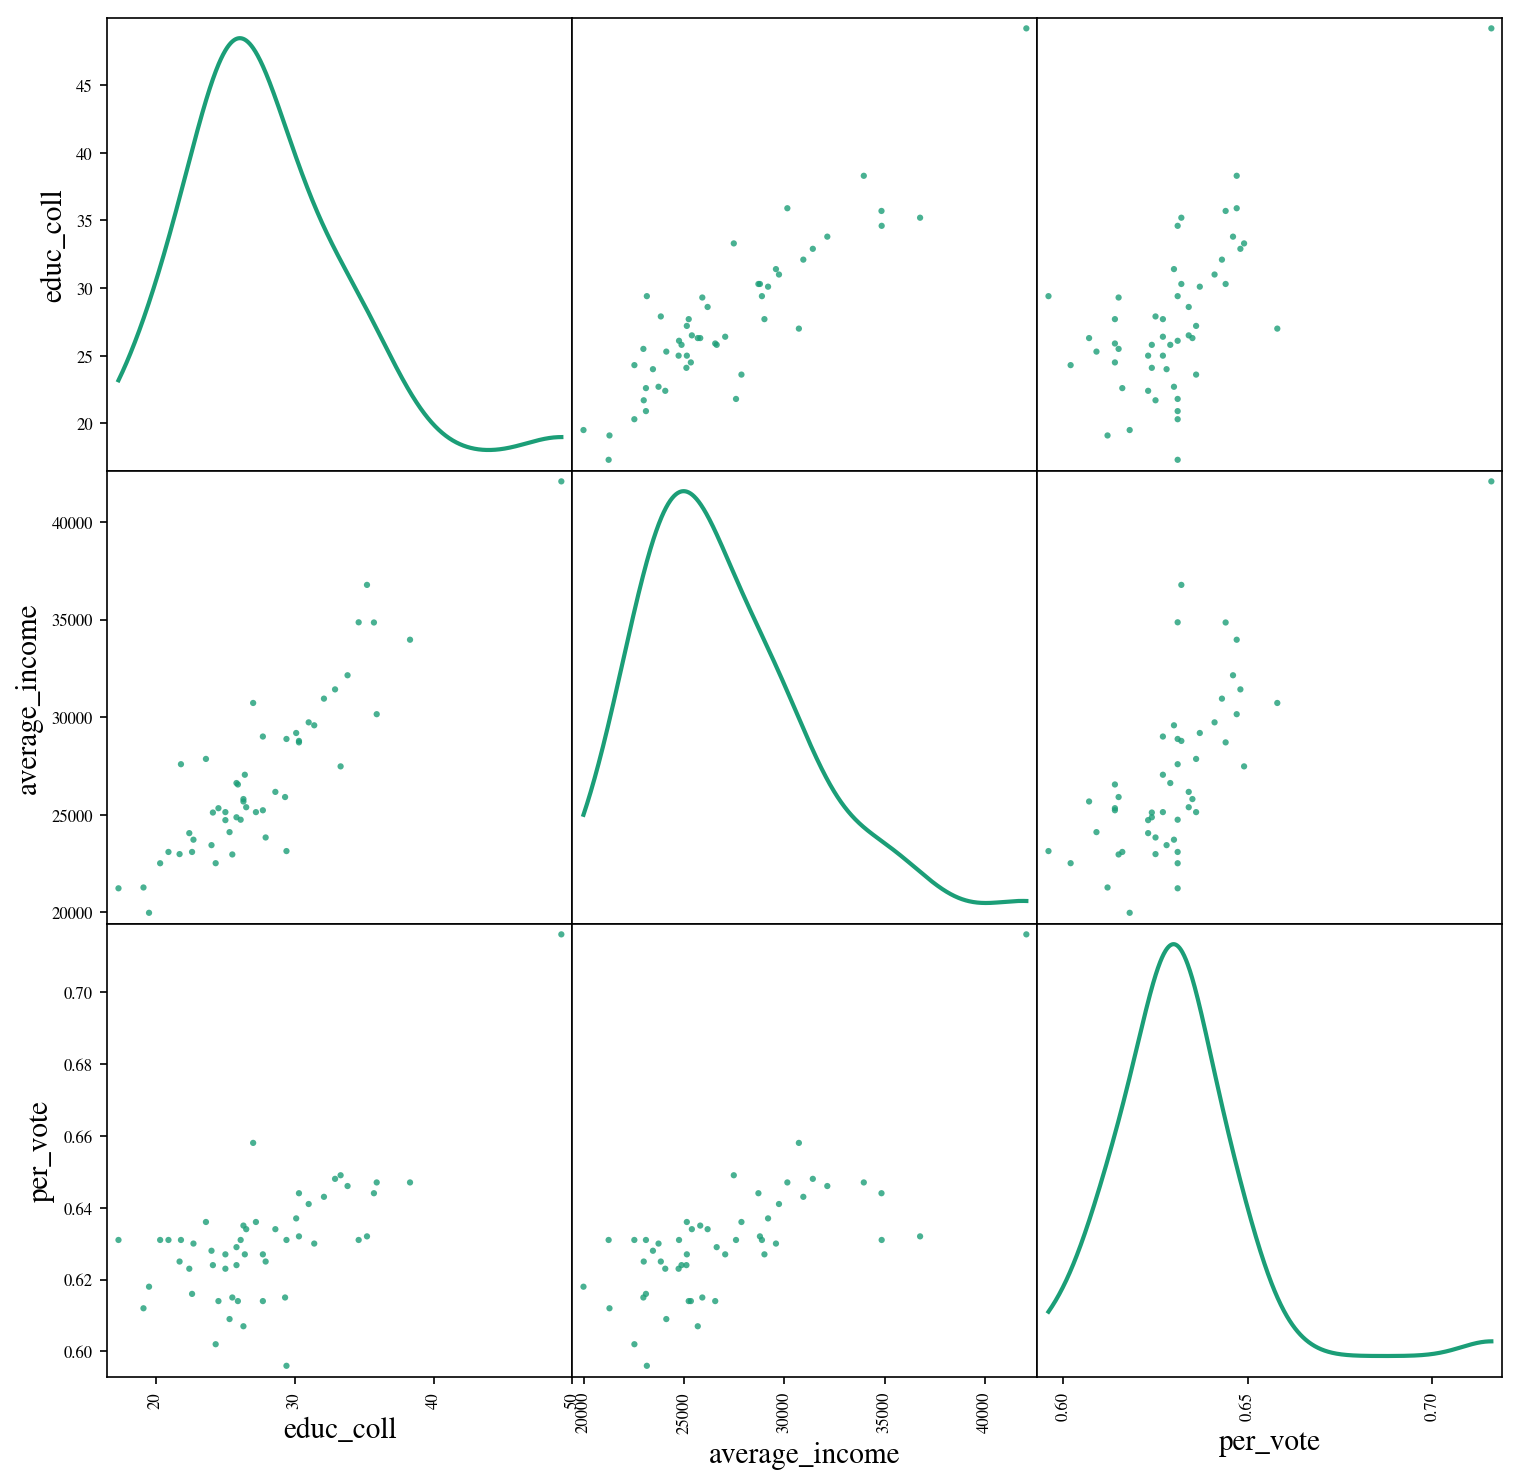

In [9]:
# use a SPLOM to visualize some columns of this dataset. 
# In pandas,  SPLOM aka scatter-matrix.
from pandas.plotting import scatter_matrix

choice = census_data[['educ_coll', 'average_income', 'per_vote']]

axeslist=scatter_matrix(choice, alpha=0.8, 
                        figsize=(12, 12), diagonal="kde")

for ax in axeslist.flatten():
    ax.grid(False)

> `average_income` seems to have a strong correlation with `educ_coll`.

We posit that the average income is higher in states which have "better" education systems and send more students to college. We confirm our intuition by seeing the `correlations`.

In [10]:
choice.corr()

,educ_coll,average_income,per_vote
educ_coll,1.000000,0.894066,0.670977
average_income,0.894066,1.000000,0.732703
per_vote,0.670977,0.732703,1.000000
